# Part I: Supervised Learining 

In [6]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request

In [7]:
#Extract data as an array from the url
# link = "http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/zipcombo.dat"
filename = 'zipcombo.dat'
training_filename = 'dtrain123.dat'
test_filename = 'dtest123.dat'
# urllib.request.urlretrieve(link, filename)
data = np.loadtxt(filename)     # read numpy array from file
# data = np.loadtxt(training_filename)     # read numpy array from file

In [8]:
data.shape

(9298, 257)

## Multiclass Perceptron with Polynomial Kernel

In [9]:
y = data[:,0]
x = data[:,1:]

In [10]:
#Not sure if I should include bias before computing the Kernel? 
def add_bias(x):
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

#Discuss the use of the this kernel. i.e. talk about non-linear seperability. 
def Polynomial_Kernel(x1,x2,d):
    K = (x1 @ x2.T)**d
    return K

def transform_y(y):
    #classes_num = len(y.unique())
    #assuming that training set has all the numbers between min(y) and max(y)
    classes_num = 10
    m = len(y)
    y_matrix = np.ones((m,classes_num))*(-1)
    for i in range(m):
        y_matrix[i,int(y[i])] = 1
    return y_matrix

In [14]:
#One vs. rest: train k classifiers to identify k classes
def perceptron_train(x,y,d=2,kernel_choice='Polynomial',max_epoch=10):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
     
    error_per_epoch = np.zeros(max_epoch)
    y_arr = transform_y(y) 
    alpha = np.zeros((m,classes_num)) #Need to store alpha array at all iteration, as we need it to compute confidence
    
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x,x,d)
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_single(x)
        K_train = Gaussian_Kernel(pairwise_distances,c=d)
    
    W = np.zeros((m,classes_num)) #with bias?
    
    for epoch in range(max_epoch):
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
        
        for t in range(m):
            if t <1:
                alpha_prev = alpha[0,:] #when t=0, the previous alpha is set to be 0     
            else:
                alpha_prev = alpha[t-1,:] #

            #find our training set
            x_t = x[t,:] #of size (1,n)
            y_t = y[t]
            y_arr_t = y_arr[t,:] #of size (1,10) 

            #pred_t computes \sum^{t-1}_{i=0} {(alpha_i K(x_t, x_i))}, which is regarded as the confidence in each class
            pred_t = (alpha[:,:].T @K_train[t,:]).T 
            
            y_hat_t = np.where(pred_t==max(pred_t),1,0) #map the confidence to arrays of 1 and 0 for class
            gamma_t = y_arr_t.T @ y_hat_t

            #if gamma_t < 0.01:
            if pred_t.argmax()!=y_t:
                #print('misclassification:',gamma_t)
                #update the alpha, and weights, for all the classes that not the true class
                num_errors +=1

                #since we only want to update the weights related to first t-1 training data.
                #note that alpha_t is np.zeros(10,1), 
                #and alpha_t is updated according to the real class, and the misclassified class.
                #this version is not updated with alpha_prev

                alpha_t = alpha[t,:] + np.where(y_arr_t> 0,1,0) + np.where(y_hat_t>0,-1,0) #(1,10)

                #store alpha_t into the matrix for future reference
                alpha[t,:] = alpha_t

                #sandwich K(x_t, x_i) for i in [1,t-1] in a zeros array of size(m). 
                #reason being weight for one class is of size(m), but we only 'have enough data' to update the first t-1 terms.  
                K_update = np.zeros((1,m))
                K_update[:,:t] = K_train[t,:t] 

                #Note that W is a weight matrix of size (m, 10)
                #K_update.T @alpha_t is the update for weight matrix, for every class and every training set that has been reviewed. 
                W = W+ K_update.T @(alpha_t.reshape(1,10)) #(1, 10) * (1,m), want (m,10)
            else:
                W = W 
        
            errors[t] = num_errors
        error_per_epoch[epoch] = errors[-1]

    return W,alpha, error_per_epoch

In [16]:
#Test this function, see if it is working properly
W,alpha, error_per_epoch = perceptron_train(x,y,d=2)

In [19]:
#Plot number of misclassfication versus the number of training sets reviewed. 
ratio = error_per_epoch/x.shape[0]
err = error_per_epoch[-1]/x.shape[0]
print("err is ", err)

err is  0.006668100666810067


Text(0.5, 1.0, 'Proportion of misclassified data points out of data points reviewed')

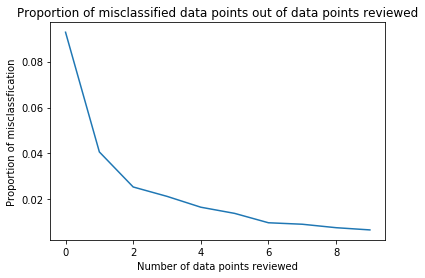

In [20]:
plt.plot(ratio)
plt.ylabel('Proportion of misclassfication')
plt.xlabel('Number of data points reviewed')
plt.title('Proportion of misclassified data points out of data points reviewed')

# Q1 - Basic Results

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd

def allocate_training_test_sets(data,r =1/5):
    X= data[:,1:]
    y= data[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)
    return X_train, X_test, y_train, y_test

In [11]:
def perceptron_test(x_test,x_train,y_test,W, alphas, d):
    K_test = Polynomial_Kernel(x_train, x_test, d)
    confidence = (alphas.T @ K_test).T
    preds = np.zeros(confidence.shape)
    mistakes = 0
    for i in range(len(y_test)):
        y_hat = confidence[i].argmax()
        preds[i,y_hat] = 1
        if y_hat != y_test[i]:
            mistakes += 1
    return mistakes, preds, confidence

In [12]:
X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
W, alphas, train_errors = perceptron_train(X_train,y_train, 3)
mistakes,_,_ = perceptron_test(X_test, X_train, y_test, W, alphas, 3)
    
print("Number of mistakes: ", mistakes, ", sample size: ", len(y_test))
print("Ratio mistakes/size: ", mistakes/len(y_test))

Number of mistakes:  104 , sample size:  1860
Ratio mistakes/size:  0.05591397849462366


In [13]:
d_arr = np.arange(1,8)
runs = 20
training_set_errors = np.zeros((len(d_arr),runs))
test_set_errors = np.zeros((len(d_arr),runs))
print("shape of errors: ", errors.shape, ", d_arr", d_arr)
for d in d_arr:
    for i in range(runs):
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)
        W, alphas,train_errors = perceptron_train(X_train,y_train, d)
        
        test_errors,_,_ = perceptron_test(X_test,X_train, y_test,W, alphas,d)
        
        training_set_errors[d-1, i] = train_errors[-1]
        test_set_errors[d-1, i] = test_errors
        print("Now doing run ", i, "/", runs, " for d=", d,".........", end='\r')

shape of errors:  (9298,) , d_arr [1 2 3 4 5 6 7]


In [14]:
means_std = []
for d in d_arr:
    data_t = []
    data_t.append("{0:.4f} +- {1:.4f}".format(training_set_errors[d-1].mean() / len(y_train), \
                                            np.std(training_set_errors[d-1]) / len(y_train)))
    data_t.append("{0:.4f} +- {1:.4f}".format(test_set_errors[d-1].mean() / len(y_test), \
                                            np.std(test_set_errors[d-1]) / len(y_test)))
    means_std.append(data_t)
    
df = pd.DataFrame(data=means_std, index=d_arr, columns=['Training set error rate', 'Test set error rate'])
df

,Training set error rate,Test set error rate
1,0.1510 +- 0.0024,0.1155 +- 0.0183
2,0.1054 +- 0.0018,0.0714 +- 0.0155
3,0.0913 +- 0.0022,0.0565 +- 0.0069
4,0.0837 +- 0.0019,0.0530 +- 0.0056
5,0.0813 +- 0.0022,0.0483 +- 0.0064
6,0.0798 +- 0.0016,0.0478 +- 0.0069
7,0.0789 +- 0.0018,0.0462 +- 0.0057


# Q2 - Cross Validation

Having already allocated x_train, now perform cross validation on x_train

In [15]:
def cross_validation(X, y, d, k):
    kf = KFold(n_splits=k, shuffle=True)
    MSE_cv_arr = np.zeros(k)
    i = 0
    for train_index, cv_index in kf.split(X):
        # Spit the matrix using the indices gained by the CV method and construct X and Y arrays
        X_train = X[train_index]
        X_cv = X[cv_index]
        y_train = y[train_index]
        y_cv = y[cv_index]
    
        # We are only interested in the alphas and not the MSE on the training set
        W, alphas, errors = perceptron_train(X_train, y_train, d)
        mistakes,_,_ = perceptron_test(X_cv, X_train, y_cv, W, alphas, d)
        MSE_cv_arr[i] = mistakes / len(y_cv)
#         print("Error rate: ", MSE_cv_arr[i])
        i += 1
        
    return MSE_cv_arr.mean(), np.std(MSE_cv_arr)

In [16]:
# This might need to be cleared up
class Confusion:
    def __init__(self, x, y, pred):
        self.x = x
        self.y = y
        self.pred = pred

In [17]:
runs = 10

d_stars = np.zeros(runs)
test_errors = np.zeros(runs)
confusion = np.zeros((10, 10))

confusion_examples = dict()
for i in range(10):
    confusion_examples[i] = []

mistakes_per_run = np.zeros(x.shape[0])
    
for j in range(runs):
    print("WARNING: Change the number of runs to 20!!!")
    # In each run we will iterate through the d array and use all possible values of d
    
    # Allocate 80/20 percent for training and test set
    X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)

    CV_means = np.zeros(len(d_arr))
    for i in range(len(d_arr)):
        print("Now doing run ", j, "/", runs, " for d=", d_arr[i], ".........", end='\r')
        MSE_CV_mean, _ = cross_validation(X_train, y_train, d_arr[i], k=5)
        CV_means[i] = MSE_CV_mean

    # Train in whole 80% now with d_star
    d_stars[j] = CV_means.argmin()
    W, alphas, errors = perceptron_train(X_train, y_train, d_stars[j])
    
    # WRONG: I think this part can be removed
    _, preds_train, confidences = perceptron_test(X_train, X_train, y_train, W, alphas, d_stars[j])
    for i in range(len(y_train)):
        pred_label = preds_train[i].argmax()
        if pred_label != y_train[i]:
            confusion[int(y_train[i]), pred_label] += 1
            confusion_examples[int(y_train[i])].append(Confusion(X_train[i], y_train[i], pred_label))
    # END WRONG
    
    mistakes,_,_ = perceptron_test(X_test, X_train, y_test, W, alphas, d_stars[j])
    test_errors[j] = mistakes / len(y_test)
    
    # Test in all the data set, so that we know which ones
    # are the "toughest" to predict in the whole data set. We can't really just do it on 
    # either the training or test set, as it is randomly split so order will not be pertained.
    _, preds_all, confidences = perceptron_test(x, X_train, y, W, alphas, d_stars[j])
    for i in range(x.shape[0]):
        pred_label = preds_all[i].argmax()
        if pred_label != y[i]:
            mistakes_per_run[i] += 1

In [18]:
print("Mean d*: ", d_stars.mean(), " with std: ", np.std(d_stars))
print("Mean test error: ", test_errors.mean(), " with std: ", np.std(test_errors))

Mean d*:  5.5  with std:  0.6708203932499369
Mean test error:  0.04897849462365591  with std:  0.007198882571527675


# Q3 - Confusion Matrix

In [19]:
#Might need to use pandas for it
df = pd.DataFrame(data=confusion)
df

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,8.0,11.0,4.0,68.0,28.0,0.0,7.0,2.0
1,1.0,0.0,6.0,3.0,84.0,2.0,28.0,9.0,7.0,10.0
2,20.0,1.0,0.0,32.0,26.0,14.0,10.0,15.0,14.0,10.0
3,3.0,1.0,21.0,0.0,0.0,115.0,0.0,3.0,30.0,5.0
4,2.0,41.0,36.0,6.0,0.0,13.0,18.0,24.0,17.0,99.0
5,21.0,0.0,2.0,42.0,4.0,0.0,17.0,1.0,30.0,6.0
6,30.0,0.0,5.0,0.0,6.0,37.0,0.0,0.0,6.0,1.0
7,0.0,8.0,21.0,8.0,31.0,5.0,0.0,0.0,4.0,128.0
8,13.0,9.0,37.0,52.0,9.0,27.0,16.0,17.0,0.0,25.0
9,2.0,4.0,0.0,6.0,28.0,9.0,0.0,31.0,18.0,0.0


# Q4 - Hardest numbers to predict

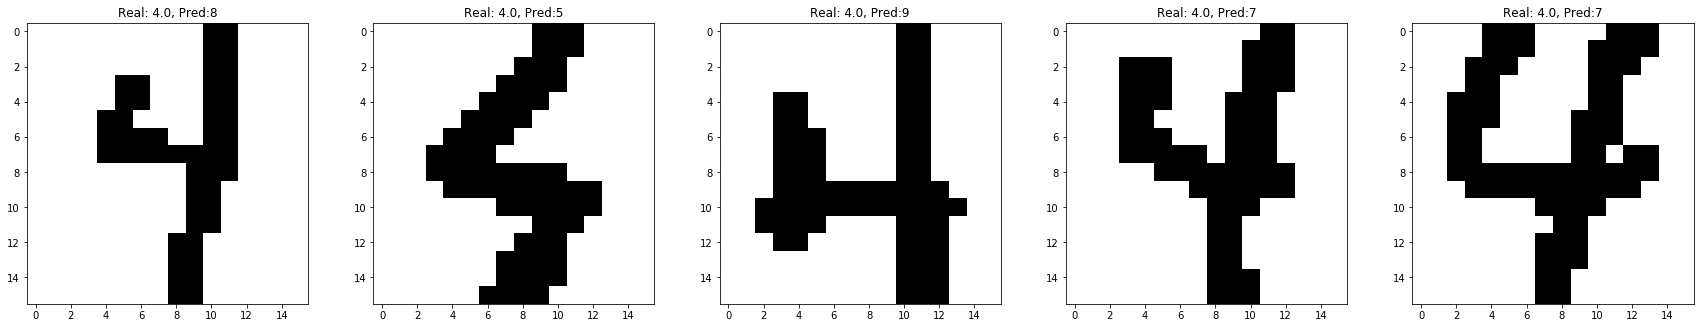

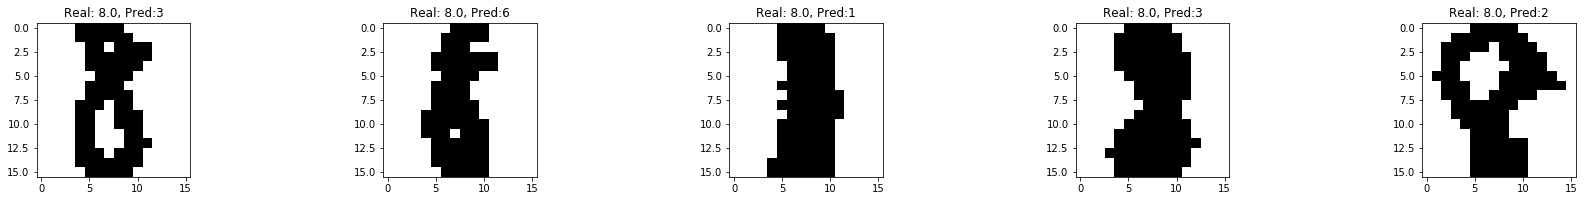

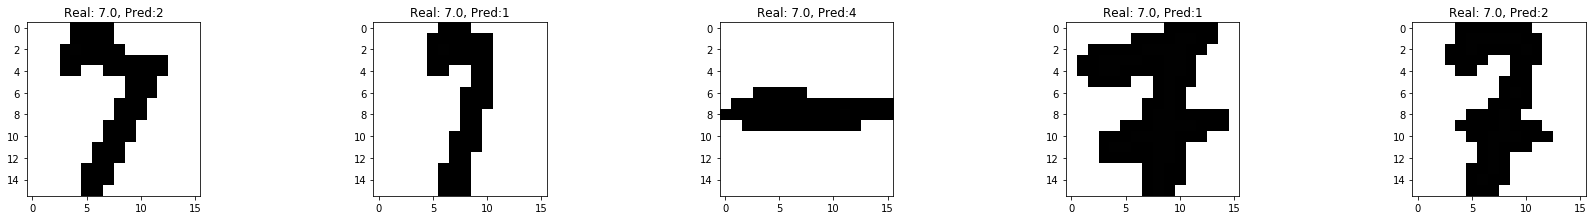

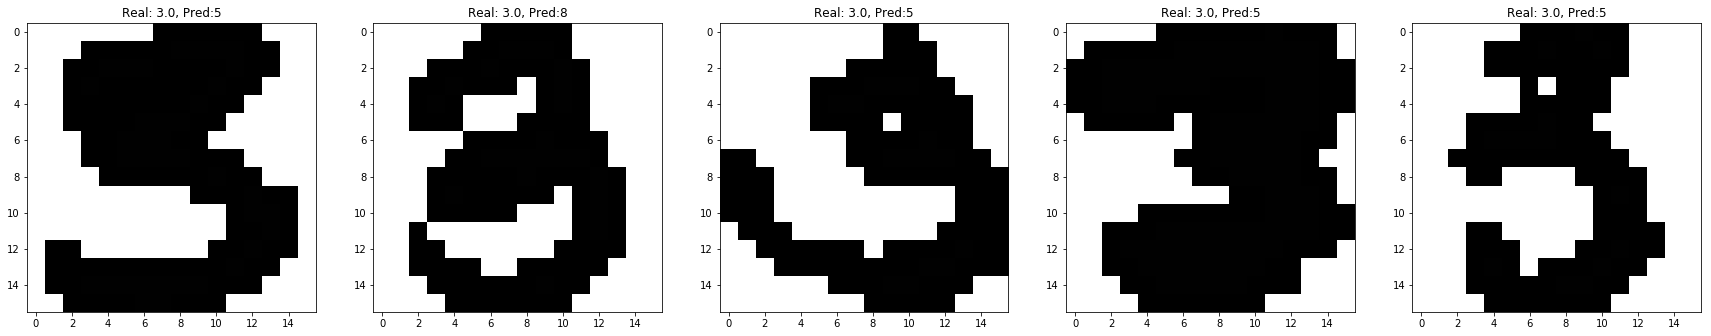

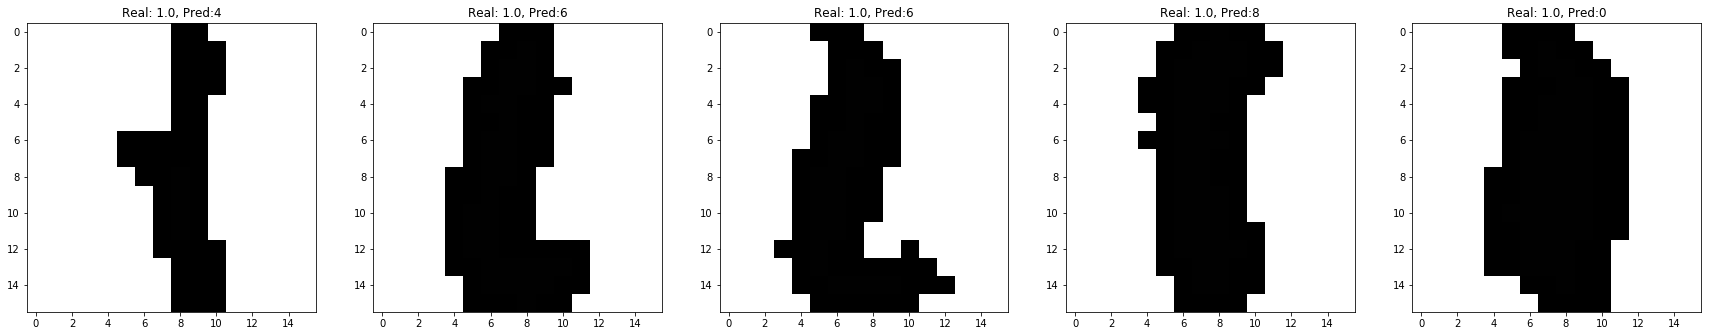

In [20]:
# WRONG: I think this is wrong based on the pdf
sums_of_confusions = np.sum(confusion, axis=1)
indices = np.flip(np.argsort(sums_of_confusions))[:5]

for i in indices:
    examples = confusion_examples[i]
    plt.figure(figsize=(30,30))
    for k in range(5):
        a1 = plt.subplot(i+1, 5, k+1)
        pixels = np.array(examples[k].x, dtype='uint8')
        pixels = pixels.reshape((16, 16))
        plt.title("Real: {0}, Pred:{1}".format(examples[k].y, examples[k].pred))
        a1.imshow(pixels, cmap='gray')

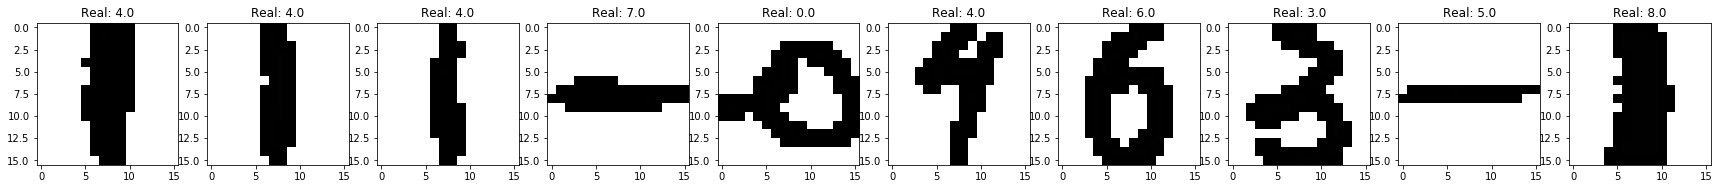

In [21]:
# The real way

# We only have to show 5, but let's show 10 for the purposes of seeingthat indeed the first 5 are the worst
indices = np.flip(np.argsort(mistakes_per_run))[:10]

plt.figure(figsize=(30,30))

k = 1
for i in indices:
    a1 = plt.subplot(1, 10, k)
    pixels = np.array(x[i], dtype='uint8')
    pixels = pixels.reshape((16, 16))
    plt.title("Real: {0}".format(y[i]))
    a1.imshow(pixels, cmap='gray')
    k+=1

# Q5 - Gaussian Kernel

In [230]:
def pairwise_distance_single(X): # distances of X training data, single X matrix
    m =X.shape[0]
    n = X.shape[1]
    G = np.matmul(X,X.T)
    DG = np.diag(G).reshape(G.shape[0],1)
    distances_sq = np.matmul(DG,np.ones((G.shape[0],1)).T)+ np.matmul(np.ones((G.shape[1],1)),DG.T)-2.0*G
    return distances_sq

def pairwise_distance_double(X1,X2): # distances of X training data, double matrices, X1 and X2
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def Gaussian_Kernel(distances_sq,c=1):
    K = np.exp(-c*distances_sq)
    return K

In [226]:
#Train with Gaussian Kernel
Wt,train_errorst = perceptron_train(x,y,d,kernel_choice='Gaussian')

t= 0
label= 6.0
alpha_t-1 []
predicted label= 0
prediction= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
gamma_t= 0.0
t= 2000
label= 0.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 0
prediction= [ 2.65827827e-31 -1.31022204e-48  2.84360679e-37 -1.50853874e-34
 -1.66918465e-40  3.59497565e-43  1.87382962e-38 -1.16290401e-42
 -2.65677277e-31  4.96633451e-46]
gamma_t= 5.3165565497897784e-31
t= 4000
label= 0.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 0
prediction= [ 2.80539063e-22 -8.70231539e-39 -1.10615619e-38 -9.78799230e-39
 -1.18839710e-37 -8.80437045e-39 -3.84603424e-27 -8.70231487e-39
 -2.80535207e-22 -9.61730222e-30]
gamma_t= 5.610781251168945e-22


In [ ]:
#Test with Gaussian Kernel
d_arr = np.arange(1,8)
for d in d_arr:
    for i in range(20):
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
        W,train_errors = perceptron_train(X_train,y_train,d,kernel_choice='Gaussian')
        test_error = perceptron_test(X_test,X_train, y_test,W,d,kernel_choice='Gaussian')

In [ ]:
#Cross Validation with Gaussian Kernel, find c_star
d_arr = np.arange(1,8)
for d in d_arr:
    for i in range(20):
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
        W,train_errors = perceptron_train(X_train,y_train,d)
        test_error = perceptron_test(X_test,X_train, y_test,W,d)

# Q6 - Choose an alternative method to generalise k-classes

# Q7 - Choose two more algorithms to compare

### Multinomial Logistic Regression 

In [238]:
#One against rest approach
#Problem: What is the hyperparameter to be tuned? C-value: C = 1/lambda, which is the regularization coefficient. 
#https://stackoverflow.com/questions/21816346/fine-tuning-parameters-in-logistic-regression
#http://dataaspirant.com/2017/05/15/implement-multinomial-logistic-regression-python/
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
# Train multi-classification model with logistic regression
lr = LogisticRegression(C=1,random_state=0, solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)

In [245]:
from sklearn import metrics
#print ("Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(x_train)))
#print ("Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(x_test)))
print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(X_test)))
 

Multinomial Logistic regression Train Accuracy ::  0.9904544232320516
Multinomial Logistic regression Test Accuracy ::  0.9354838709677419


In [ ]:
# Different ideas - LR uses probability theory, it'd be interest to compare with perceptron which is simply geometric. 

### Support Vector

In [ ]:
#One against one approach, or One against All approach? 

In [ ]:
#Maybe logistic regression and SVM. 
